In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import KFold, StratifiedKFold,cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import random
from keras.wrappers.scikit_learn import KerasClassifier
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 50)

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/data/credit/train.csv")
duptrain = pd.read_csv("/content/drive/MyDrive/data/credit/train.csv")
test = pd.read_csv("/content/drive/MyDrive/data/credit/test.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/data/credit/sample_submission.csv")

In [ ]:
df_train=train.copy()
df_test=test.copy()

In [ ]:
print(train.shape,test.shape)

(26457, 20) (10000, 19)


In [ ]:
df_train['fmi_income_ratio'] = df_train['income_total']/df_train['family_size'] # + +
df_test['fmi_income_ratio'] = df_test['income_total']/df_test['family_size']


df_train['INCOME_BIRTH_RATIO'] = -(df_train['income_total']/df_train['DAYS_BIRTH']) #+ -
df_test['INCOME_BIRTH_RATIO'] =-( df_test['income_total']/df_test['DAYS_BIRTH'])


df_train['EMPLOYED_BIRTH_RATIO'] = df_train['DAYS_EMPLOYED']/df_train['DAYS_BIRTH'] #- -
df_test['EMPLOYED_BIRTH_RATIO'] = df_test['DAYS_EMPLOYED']/df_test['DAYS_BIRTH']

df_train['INCOME_EMPLOYED_RATIO'] = -(df_train['income_total']/df_train['DAYS_EMPLOYED']) #+ -
df_test['INCOME_EMPLOYED_RATIO'] = -(df_test['income_total']/df_test['DAYS_EMPLOYED'])


df_train['begin_month_EMPLOYED_RATIO'] = -(df_train['DAYS_EMPLOYED']/(df_train['begin_month']*30)) #+ -
df_test['begin_month_EMPLOYED_RATIO'] = -(df_test['DAYS_EMPLOYED']/(df_train['begin_month']*30))



In [ ]:

df_train.loc[df_train['INCOME_EMPLOYED_RATIO']<=0,'INCOME_EMPLOYED_RATIO']=0
df_train.loc[df_train['EMPLOYED_BIRTH_RATIO']<=0,'EMPLOYED_BIRTH_RATIO']=0
df_test.loc[df_test['INCOME_EMPLOYED_RATIO']<=0,'INCOME_EMPLOYED_RATIO']=0
df_test.loc[df_test['EMPLOYED_BIRTH_RATIO']<=0,'EMPLOYED_BIRTH_RATIO']=0



In [ ]:
## GROUPBY - 2 : 두개의 변수를 묶어서 변환
df_train['gender_car'] = (
                                                df_train.gender.astype(str)
                                                +'_'
                                                + df_train.car.astype(str)
)

display(df_train['gender_car'].head())
display(df_train.groupby(['gender_car'])['index'].count().reset_index(name = 'count').sort_values(by='count'))

0    F_N
1    F_N
2    M_Y
3    F_N
4    F_Y
Name: gender_car, dtype: object

,gender_car,count
2,M_N,3244
1,F_Y,4531
3,M_Y,5516
0,F_N,13166


In [ ]:
## GROUPBY - 2 : 두개의 변수를 묶어서 변환
df_test['gender_car'] = (
                                                df_test.gender.astype(str)
                                                +'_'
                                                + df_test.car.astype(str)
)

display(df_test['gender_car'].head())
display(df_test.groupby(['gender_car'])['index'].count().reset_index(name = 'count').sort_values(by='count'))

0    M_Y
1    F_N
2    F_N
3    M_Y
4    F_Y
Name: gender_car, dtype: object

,gender_car,count
2,M_N,1210
1,F_Y,1739
3,M_Y,2057
0,F_N,4994


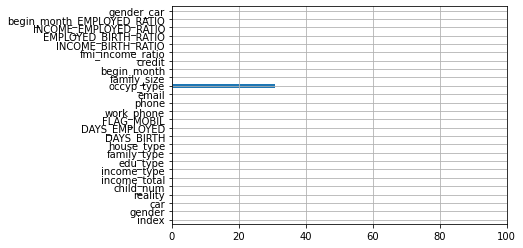

In [ ]:
(1e2 * df_train.isnull().sum()/len(df_train)).plot(kind='barh')
plt.xlim(0, 10**2)
plt.grid();

In [ ]:



df_train['DAYS_BIRTH'] = (df_train['DAYS_BIRTH'] * (-1)) / 365
df_test['DAYS_BIRTH'] = (df_test['DAYS_BIRTH'] * (-1)) / 365
df_train['begin_month'] = df_train['begin_month'] * (-1)
df_test['begin_month'] = df_test['begin_month'] * (-1)



df_train.loc[df_train['child_num'] > 8,'child_num'] = 9
df_test.loc[df_test['child_num'] > 8,'child_num'] = 9

In [ ]:
df_train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,fmi_income_ratio,INCOME_BIRTH_RATIO,EMPLOYED_BIRTH_RATIO,INCOME_EMPLOYED_RATIO,begin_month_EMPLOYED_RATIO,gender_car
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,38.079452,-4709,1,0,0,0,NaN,2.0,6.0,1.0,101250.0,14.569393,0.338801,43.002761,-26.161111,F_N
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,31.178082,-1540,1,0,0,1,Laborers,3.0,5.0,1.0,82500.0,21.748682,0.135325,160.714286,-10.266667,F_N
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,52.293151,-4434,1,0,1,0,Managers,2.0,22.0,2.0,225000.0,23.576256,0.232305,101.488498,-6.718182,M_Y
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,41.336986,-2092,1,0,1,0,Sales staff,2.0,37.0,0.0,101250.0,13.421262,0.138653,96.797323,-1.884685,F_N
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,41.197260,-2105,1,0,0,0,Managers,2.0,26.0,2.0,78750.0,10.474164,0.139988,74.821853,-2.698718,F_Y


In [ ]:
interval_income = (0,100000, 200000, 300000, 400000, 500000, 99999999)
cats_income = [0,1,2,3,4,5]
df_train['income_total_category'] = pd.cut(df_train.income_total, interval_income, labels=cats_income)
df_test['income_total_category'] = pd.cut(df_train.income_total, interval_income, labels=cats_income)

In [ ]:
df_train.loc[df_train['DAYS_EMPLOYED']==365243, 'occyp_type']= 'nojob'
df_test.loc[df_test['DAYS_EMPLOYED']==365243, 'occyp_type']= 'nojob'

In [ ]:
df_train.loc[df_train['DAYS_EMPLOYED']==365243,:].head(2)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,fmi_income_ratio,INCOME_BIRTH_RATIO,EMPLOYED_BIRTH_RATIO,INCOME_EMPLOYED_RATIO,begin_month_EMPLOYED_RATIO,gender_car,income_total_category
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,62.800000,365243,1,0,1,0,nojob,1.0,41.0,2.0,157500.0,6.871128,0.0,0.0,296.945528,F_N,1
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,63.323288,365243,1,0,0,0,nojob,2.0,37.0,2.0,108000.0,9.345390,0.0,0.0,329.047748,F_N,2


In [ ]:
train_data=df_train.copy()
test_data=df_test.copy()

In [ ]:
train_data.loc[df_train['DAYS_EMPLOYED'] ==365243,'DAYS_EMPLOYED'] = 0
test_data.loc[df_test['DAYS_EMPLOYED'] ==365243,'DAYS_EMPLOYED'] = 0

In [ ]:

label_encoder=preprocessing.LabelEncoder()

train_data['gender'] = train_data['gender'].replace(['F','M'],[1,0])
test_data['gender'] = test_data['gender'].replace(['F','M'],[1,0])

train_data['car'] = train_data['car'].replace(['N','Y'],[1,0])
test_data['car'] = test_data['car'].replace(['N','Y'],[1,0])

train_data['reality'] = train_data['reality'].replace(['N','Y'],[1,0])
test_data['reality'] = test_data['reality'].replace(['N','Y'],[1,0])



edu_type_map = {
    'Lower secondary' : 0, # 중학교 미만
    'Secondary / secondary special' : 1, #중학교
    'Incomplete higher' : 2, # 고등학교 중퇴
    'Higher education' : 3, # 고등학교 졸업
     'Academic degree' : 4 # 학사 이상
         }
train_data.loc[:,'edu_type'] = train_data['edu_type'].map(edu_type_map)
test_data.loc[:,'edu_type'] = test_data['edu_type'].map(edu_type_map)

income_type_map = {
'Student':0,
'Pensioner':1,
'Working':2,
'State servant':3,
'Commercial associate':4
         }
train_data.loc[:,'income_type'] = train_data['income_type'].map(income_type_map)
test_data.loc[:,'income_type'] = test_data['income_type'].map(income_type_map)

family_type_map = {
'Married':0,
'Civil marriage':1,
'Widow':2,
'Separated':3,
'Single / not married':4,}
train_data.loc[:,'family_type'] = train_data['family_type'].map(family_type_map)
test_data.loc[:,'family_type'] = test_data['family_type'].map(family_type_map)

house_type_map = {
'Co-op apartment':0,
'With parents':1,
'Municipal apartment':2,
'House / apartment':3,
'Office apartment':4,
'Rented apartment':5
         }
train_data.loc[:,'house_type'] = train_data['house_type'].map(house_type_map)
test_data.loc[:,'house_type'] = test_data['house_type'].map(house_type_map)

occyp_type_map = {#임금기준
'Realty agents':18,
'Managers':17,
'Private service staff':16,
'Secretaries':15,
'Security staff':14,
'Drivers':13,
'Accountants':12,
'Core staff':11,
'High skill tech staff':10,
'HR staff':9,
'IT staff':8,
'Sales staff':7,
'Laborers':6,
'Medicine staff':5,
'Cooking staff':4,
'Waiters/barmen staff':3,
'Low-skill Laborers':2,
'Cleaning staff':1,
'nojob':0


}

train_data.loc[:,'occyp_type'] = train_data['occyp_type'].map(occyp_type_map)
test_data.loc[:,'occyp_type'] = test_data['occyp_type'].map(occyp_type_map)


gender_car_map = {
'M_Y':0,
'F_Y':1,
'M_N':2,
'F_N':3,
  }
train_data.loc[:,'gender_car'] = train_data['gender_car'].map(gender_car_map)
test_data.loc[:,'gender_car'] = test_data['gender_car'].map(gender_car_map)










In [ ]:
train_data.loc[train_data['occyp_type'].isnull()]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,fmi_income_ratio,INCOME_BIRTH_RATIO,EMPLOYED_BIRTH_RATIO,INCOME_EMPLOYED_RATIO,begin_month_EMPLOYED_RATIO,gender_car,income_total_category
0,0,1,1,1,0,202500.0,4,3,0,2,38.079452,-4709,1,0,0,0,NaN,2.0,6.0,1.0,101250.0,14.569393,0.338801,43.002761,-26.161111,3,2
8,8,0,0,0,1,180000.0,4,3,0,3,41.454795,-1466,1,0,0,1,NaN,3.0,38.0,2.0,60000.0,11.896107,0.096887,122.783083,-1.285965,0,1
19,19,1,1,0,0,180000.0,2,1,0,3,37.608219,-6031,1,0,0,0,NaN,2.0,7.0,2.0,90000.0,13.112843,0.439353,29.845797,-28.719048,3,1
20,20,0,1,1,0,180000.0,2,1,0,3,54.383562,-1753,1,0,1,0,NaN,2.0,35.0,2.0,90000.0,9.068010,0.088312,102.681118,-1.669524,2,1
23,23,0,0,1,0,225000.0,2,1,0,2,39.841096,-444,1,1,1,1,NaN,2.0,18.0,2.0,112500.0,15.472425,0.030532,506.756757,-0.822222,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26433,26433,1,0,1,0,121500.0,3,3,0,3,54.553425,-4973,1,0,1,0,NaN,2.0,31.0,2.0,60750.0,6.101848,0.249749,24.431932,-5.347312,1,1
26435,26435,1,1,1,1,126000.0,2,1,2,3,53.947945,-473,1,0,0,0,NaN,2.0,40.0,2.0,63000.0,6.398862,0.024021,266.384778,-0.394167,3,1
26437,26437,0,1,0,0,180000.0,2,1,0,3,35.657534,-3647,1,0,0,0,NaN,2.0,13.0,2.0,90000.0,13.830196,0.280215,49.355635,-9.351282,2,1
26449,26449,1,1,1,0,90000.0,2,1,0,3,28.761644,-2418,1,1,1,0,NaN,2.0,2.0,1.0,45000.0,8.573062,0.230330,37.220844,-40.300000,3,0


In [ ]:
train_data['DAYS_EMPLOYED'] = train_data ['DAYS_EMPLOYED'] * (-1) 
test_data['DAYS_EMPLOYED'] = test_data ['DAYS_EMPLOYED'] * (-1) 

In [ ]:

from sklearn import linear_model

train_lin_reg = linear_model.LinearRegression()



X = train_data.dropna(axis=0)[['gender','INCOME_BIRTH_RATIO','INCOME_EMPLOYED_RATIO']] 
y = train_data.dropna(axis=0)['occyp_type'] 

train_lin_reg_model = train_lin_reg.fit(X,y)

y_pred = train_lin_reg_model.predict(train_data.loc[:, ['gender','INCOME_BIRTH_RATIO','INCOME_EMPLOYED_RATIO']])

y_pred
train_data['occyp_type'] = np.where(train_data['occyp_type'].isnull(), pd.Series(y_pred.flatten()), train_data['occyp_type'])
train_data['occyp_type']=train_data['occyp_type'].round(0).astype(int)#반올림


In [ ]:


test_lin_reg = linear_model.LinearRegression()

X = test_data.dropna(axis=0)[['gender','INCOME_BIRTH_RATIO','INCOME_EMPLOYED_RATIO']] 
y = test_data.dropna(axis=0)['occyp_type'] 

test_lin_reg_model = test_lin_reg.fit(X,y)

y_pred = test_lin_reg_model.predict(test_data.loc[:, ['gender','INCOME_BIRTH_RATIO','INCOME_EMPLOYED_RATIO']])

y_pred
test_data['occyp_type'] = np.where(test_data['occyp_type'].isnull(), pd.Series(y_pred.flatten()), test_data['occyp_type'])
test_data['occyp_type']=test_data['occyp_type'].round(0).astype(int)#반올림


In [ ]:
interval_occyp_type = (-3,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,999)
cats_occyp_type = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
train_data['occyp_type'] = pd.cut(train_data.occyp_type, interval_occyp_type, labels=cats_occyp_type)
test_data['occyp_type'] = pd.cut(test_data.occyp_type, interval_occyp_type, labels=cats_occyp_type)

In [ ]:
train_data['ID'] = \
    train_data['child_num'].astype(str) + '_' + train_data['income_total'].astype(str) + '_' +\
    train_data['DAYS_BIRTH'].astype(str) + '_' + train_data['DAYS_EMPLOYED'].astype(str) + '_' +\
    train_data['work_phone'].astype(str) + '_' + train_data['phone'].astype(str) + '_' +\
    train_data['email'].astype(str) + '_' + train_data['family_size'].astype(str) + '_' +\
    train_data['gender'].astype(str) + '_' + train_data['car'].astype(str) + '_' +\
    train_data['reality'].astype(str) + '_' + train_data['income_type'].astype(str) + '_' +\
    train_data['edu_type'].astype(str) + '_' + train_data['family_type'].astype(str) + '_' +\
    train_data['house_type'].astype(str) + '_' + train_data['occyp_type'].astype(str)

In [ ]:
test_data['ID'] = \
    test_data['child_num'].astype(str) + '_' + test_data['income_total'].astype(str) + '_' +\
    test_data['DAYS_BIRTH'].astype(str) + '_' + test_data['DAYS_EMPLOYED'].astype(str) + '_' +\
    test_data['work_phone'].astype(str) + '_' + test_data['phone'].astype(str) + '_' +\
    test_data['email'].astype(str) + '_' + test_data['family_size'].astype(str) + '_' +\
    test_data['gender'].astype(str) + '_' + test_data['car'].astype(str) + '_' +\
    test_data['reality'].astype(str) + '_' + test_data['income_type'].astype(str) + '_' +\
    test_data['edu_type'].astype(str) + '_' + test_data['family_type'].astype(str) + '_' +\
    test_data['house_type'].astype(str) + '_' + test_data['occyp_type'].astype(str)

In [ ]:
label_encoder=preprocessing.LabelEncoder()
train_data['ID']=label_encoder.fit_transform(train_data['ID'])
test_data['ID']=label_encoder.fit_transform(test_data['ID'])


In [ ]:
test_data.head(2)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,fmi_income_ratio,INCOME_BIRTH_RATIO,EMPLOYED_BIRTH_RATIO,INCOME_EMPLOYED_RATIO,begin_month_EMPLOYED_RATIO,gender_car,income_total_category,ID
0,26457,0,0,1,0,112500.0,1,1,1,3,60.246575,0,1,0,1,0,0,2.0,60.0,56250.0,5.115962,0.000000,0.000000,2029.127778,0,2,334
1,26458,1,1,0,0,135000.0,3,3,0,3,51.956164,8671,1,0,1,0,11,2.0,36.0,67500.0,7.118751,0.457235,15.569139,-57.806667,3,2,851


In [ ]:
train_data['DAYS_EMPLOYED'] = train_data ['DAYS_EMPLOYED'] / 365
test_data['DAYS_EMPLOYED'] = test_data ['DAYS_EMPLOYED']  / 365


interval_INCOME_EMPLOYED_RATIO = (-1,0,100,200,300,400,9999999)
cats_INCOME_EMPLOYED_RATIO = [0,1,2,3,4,5]
train_data['INCOME_EMPLOYED_RATIO_category'] = pd.cut(train_data.INCOME_EMPLOYED_RATIO, interval_INCOME_EMPLOYED_RATIO, labels=cats_INCOME_EMPLOYED_RATIO)
test_data['INCOME_EMPLOYED_RATIO_category'] = pd.cut(test_data.INCOME_EMPLOYED_RATIO, interval_INCOME_EMPLOYED_RATIO, labels=cats_INCOME_EMPLOYED_RATIO)


interval_fmi_income_ratio = (0,100000, 200000, 300000, 400000, 99999999)

cats_fmi_income_ratio = [0,1,2,3,4]
train_data['fmi_income_ratio_category'] = pd.cut(train_data.fmi_income_ratio, interval_fmi_income_ratio, labels=cats_fmi_income_ratio)
test_data['fmi_income_ratio_category'] = pd.cut(test_data.fmi_income_ratio, interval_fmi_income_ratio, labels=cats_fmi_income_ratio)



interval_EMPLOYED_BIRTH_RATIO = (-.03,0,.02,.04,.06,.08,99999)

cats_EMPLOYED_BIRTH_RATIO = [0,1,2,3,4,5]
train_data['EMPLOYED_BIRTH_RATIO_category'] = pd.cut(train_data.EMPLOYED_BIRTH_RATIO, interval_EMPLOYED_BIRTH_RATIO, labels=cats_EMPLOYED_BIRTH_RATIO)
test_data['EMPLOYED_BIRTH_RATIO_category'] = pd.cut(test_data.EMPLOYED_BIRTH_RATIO, interval_EMPLOYED_BIRTH_RATIO, labels=cats_EMPLOYED_BIRTH_RATIO)


interval_INCOME_BIRTH_RATIO = (-30,0,10,20,30,40,999999999)

cats_INCOME_BIRTH_RATIO = [0,1,2,3,4,5]
train_data['INCOME_BIRTH_RATIO_category'] = pd.cut(train_data.INCOME_BIRTH_RATIO, interval_INCOME_BIRTH_RATIO, labels=cats_INCOME_BIRTH_RATIO)
test_data['INCOME_BIRTH_RATIO_category'] = pd.cut(test_data.INCOME_BIRTH_RATIO, interval_INCOME_BIRTH_RATIO, labels=cats_INCOME_BIRTH_RATIO)

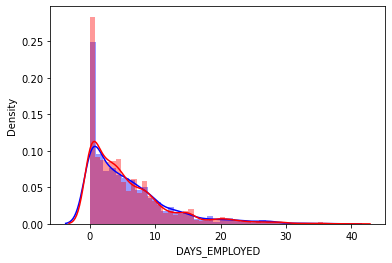

In [ ]:
#cond2 = (train_data['credit'] == 2)
cond1 = (train_data['credit'] == 1)
cond0 = (train_data['credit'] == 0)

cond_amt = (train_data['DAYS_EMPLOYED'] <40)

sns.distplot(train_data[cond0 & cond_amt]['DAYS_EMPLOYED'], label='0', color='blue')
sns.distplot(train_data[cond1 & cond_amt]['DAYS_EMPLOYED'], label='1', color='red')
#sns.distplot(train_data[cond2 & cond_amt]['DAYS_EMPLOYED'], label='2', color='green')

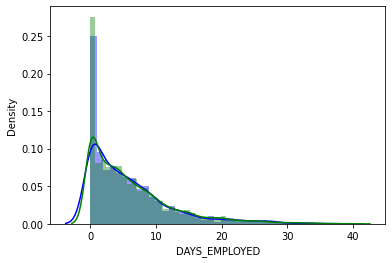

In [ ]:
cond2 = (train_data['credit'] == 2)
#cond1 = (train_data['credit'] == 1)
cond0 = (train_data['credit'] == 0)

cond_amt = (train_data['DAYS_EMPLOYED'] <40  )
sns.distplot(train_data[cond0 & cond_amt]['DAYS_EMPLOYED'], label='0', color='blue')
#sns.distplot(train_data[cond1 & cond_amt]['DAYS_EMPLOYED'], label='1', color='red')
sns.distplot(train_data[cond2 & cond_amt]['DAYS_EMPLOYED'], label='2', color='green')

In [ ]:
def show_hist_by_credit(train_data, columns):
    cond_2 = (train_data['credit'] == 2)
    cond_1 = (train_data['credit'] == 1)
    cond_0 = (train_data['credit'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), squeeze=False)
        sns.distplot(train_data[cond_0][column], ax=axs[0][0], label='0', color='red')
        sns.distplot(train_data[cond_1][column], ax=axs[0][0], label='1', color='blue')
        sns.distplot(train_data[cond_0][column], ax=axs[0][1], label='0', color='red')
        sns.distplot(train_data[cond_2][column], ax=axs[0][1], label='2', color='green')

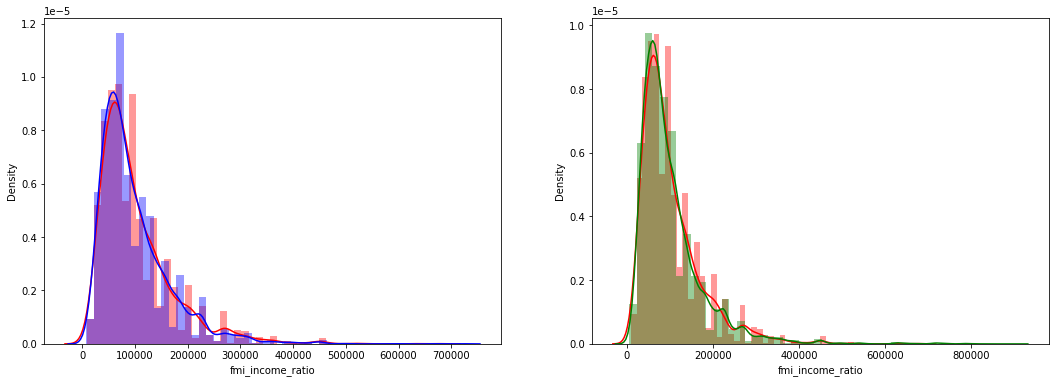

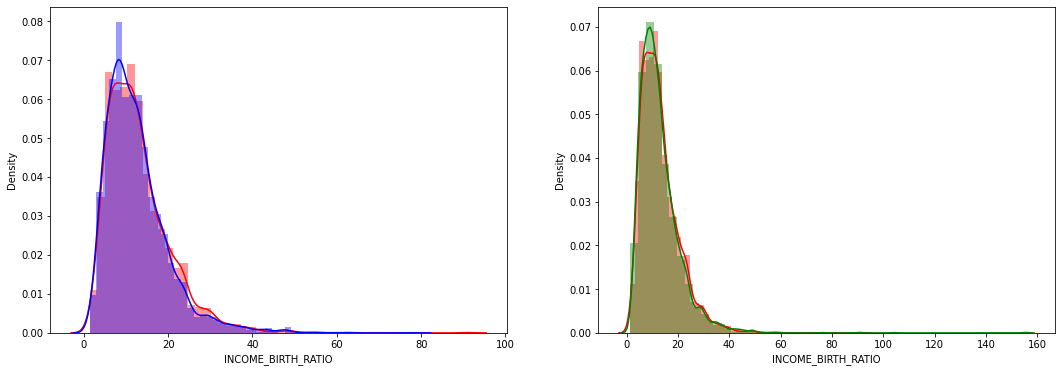

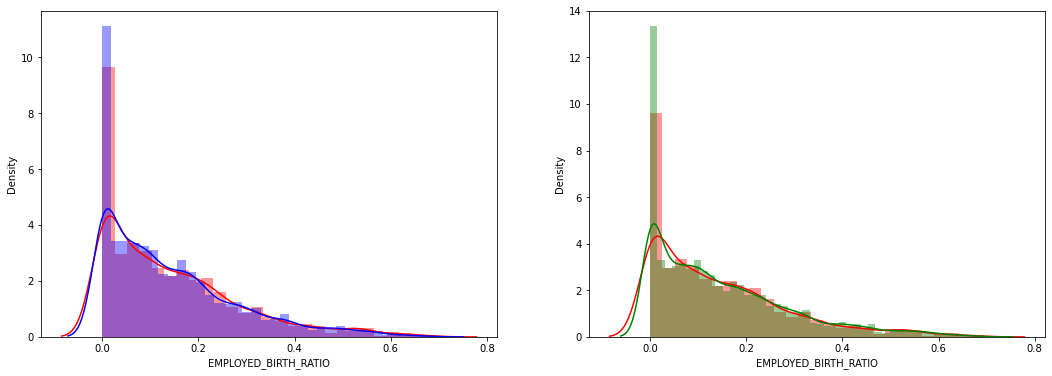

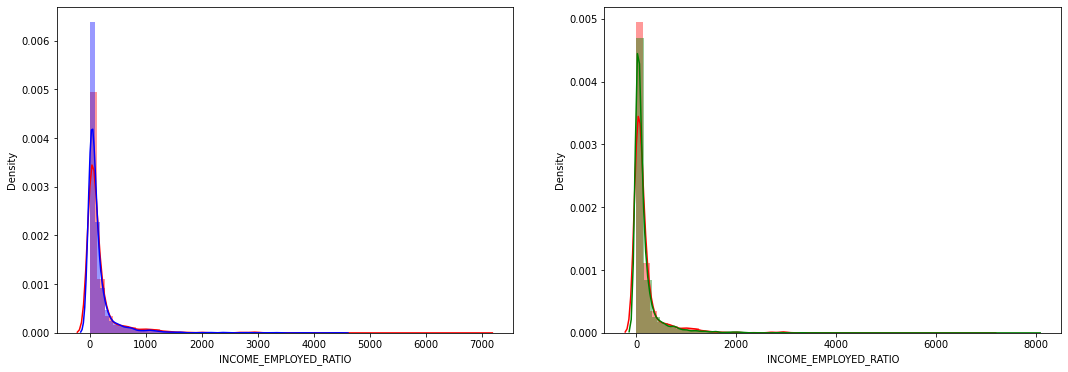

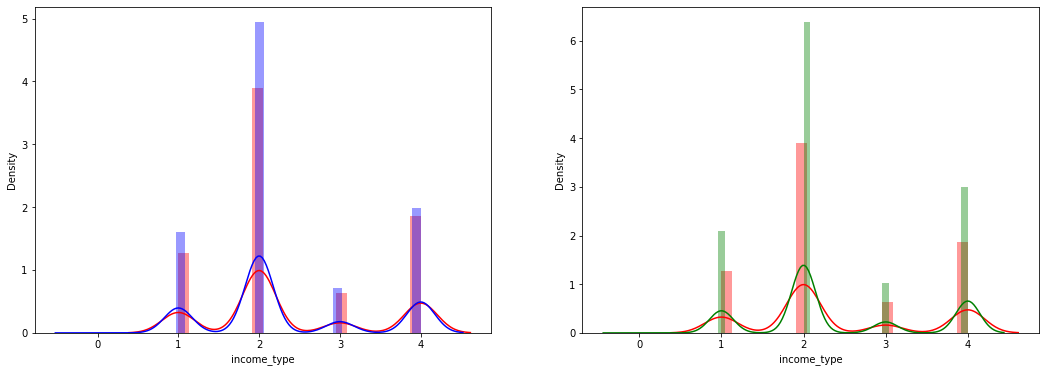

In [ ]:
columns = ['fmi_income_ratio', 'INCOME_BIRTH_RATIO', 'EMPLOYED_BIRTH_RATIO',
       'INCOME_EMPLOYED_RATIO','income_type']

show_hist_by_credit(train_data, columns)

In [ ]:
train_data.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit',
       'fmi_income_ratio', 'INCOME_BIRTH_RATIO', 'EMPLOYED_BIRTH_RATIO',
       'INCOME_EMPLOYED_RATIO', 'begin_month_EMPLOYED_RATIO', 'gender_car',
       'income_total_category', 'ID', 'INCOME_EMPLOYED_RATIO_category',
       'fmi_income_ratio_category', 'EMPLOYED_BIRTH_RATIO_category',
       'INCOME_BIRTH_RATIO_category'],
      dtype='object')

In [ ]:
test_data=test_data.drop(['index','income_total'],axis=1)

In [ ]:
ftr_app = train_data.drop(['index', 'credit','income_total'], axis=1) 
target_app = train_data['credit']
test_x = test_data

In [ ]:
ftr_app.shape

(26457, 29)

In [ ]:
target_app.shape

(26457,)

In [ ]:
test_x.shape

(10000, 29)

In [ ]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2021)
train_x.shape, valid_x.shape


((18519, 29), (7938, 29))

In [ ]:


from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        learning_rate = 0.01,
        num_leaves = 20,
        n_estimators = 100,
        max_depth= -1,
        min_child_weight = 2, 
        subsample = 0.8,
        colsample_bytree = 0.5,
        objective = 'multiclass',
        n_jobs= -1
 )

 
clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'multi_logloss',
verbose= 100, early_stopping_rounds= 200)


Training until validation scores don't improve for 200 rounds.
[100]	training's multi_logloss: 0.815853	training's multi_logloss: 0.815853	valid_1's multi_logloss: 0.836443	valid_1's multi_logloss: 0.836443
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.815853	training's multi_logloss: 0.815853	valid_1's multi_logloss: 0.836443	valid_1's multi_logloss: 0.836443


LGBMClassifier(colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2,
               num_leaves=20, objective='multiclass', subsample=0.8)

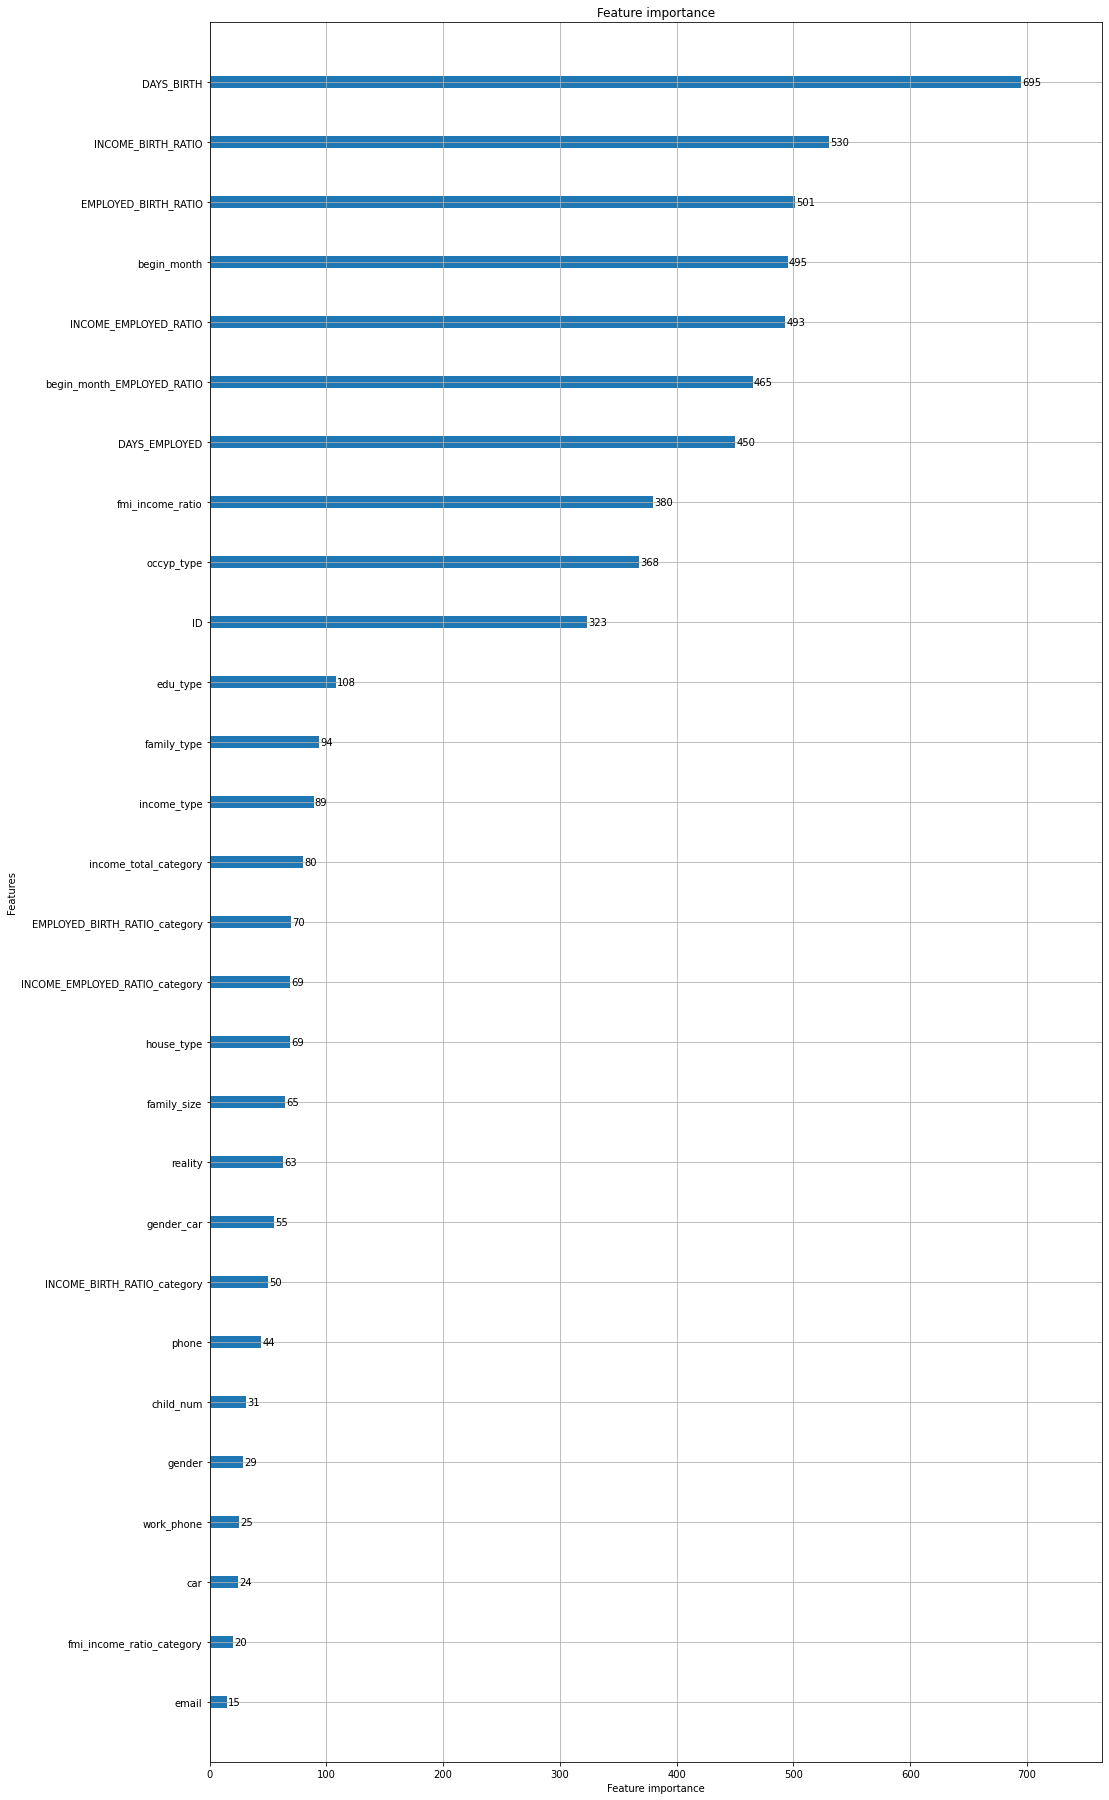

In [ ]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))